# PyHSMM Experiment Collection


This notebook provides all functionalities to run experiments with the updated version of the pyhsmm package (originally from `matjj`). 

---

## 0. Setup of the Environment

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyhsmm.basic.distributions import PoissonDuration, NegativeBinomialDuration, NegativeBinomialFixedRDuration
from pyhsmm.models import WeakLimitHDPHSMM, HSMM
from pybasicbayes.distributions.gaussian import Gaussian
from pybasicbayes.distributions.multinomial import Categorical
from pybasicbayes.distributions.mixturedistribution import DistributionMixture
import pickle
from pyhsmm.util.eaf_processing import to_eaf
import random
import sys
import ipywidgets as widgets
import datetime

sys.path.insert(1,'/home/daniel/PycharmProjects/virtamed')

from helpers import get_list_of_files, load_zipped_pickle

np.random.seed(1001)
random.seed(1001)

---

## 1. Initial Experiment 01/12/2020 (NPT HSMM)

The first experiment that we will conduct has the following setup:

**Observables:**
 * NextPedalType (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 
We will not make use of the Bayesian formulation of the HSMM model components namely the emission, transition, duration and initial state distribution model. For that reason even though we define sometimes respective hyperparameters, those will be chosen in such a way that they essential are uninformative priors. The results will thus be purely identified by the data.
 
As for the model components we make the following distributional assumptions:
 
 * categorical emission model
 * categorical transition model
 * negative binomial duration distribution model
 * categorical initial state distribution model

### 1a. Read in the data

In [2]:
def read_data_from_disk(root_dir, limit=None):
    file_list = get_list_of_files(root_dir)
    obs_array = []
    records = []
    data_frames = []
    eaf_fnames = []
    for fname in file_list:
        print('Got data for ' + fname)
        data_dict = load_zipped_pickle(fname)
        obs_array.append(data_dict['obs'])
        records.append(data_dict['record'])
        data_frames.append(data_dict['decode_df'])
        eaf_fnames.append(data_dict['eaf_path'])
    
    return obs_array, records, data_frames, eaf_fnames

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [3]:
root_dir = '/home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_12_47_42_257.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_12_51_23_562.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_12_57_05_692.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_13_01_17_229.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_13_10_39_252.zip
Got data for /home/daniel/PycharmProjects/pyhsmm-develop/thesis/data/data_from_virtamed/pyhsmm_data_thesis/npt_ground_truth_data/pyhsmm_data/2018_01_18_13_

---

###  1b. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### 1b. i) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [4]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

#### 1b. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [5]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.120, 0.410, 0.410, 0.000, 0.050],       #clear view
  #[0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  [0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### 1b. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [6]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 1

#### 1b. iv) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [7]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
#duration_negbin_rs = np.array([2000.171344, 100.477453 , 100.446388,  150.481516,  100.454518, 1000.125309])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])
#duration_negbin_ps = np.array([0.05717104, 0.07135187, 0.07054303, 0.07130548, 0.07084420, 0.09145630])

#### 1b. vi) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [8]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.33615819,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429],[0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.03115265,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.07943925,0.07632399,0.01557632,0.07943925,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.05451713,0.02492212,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632],[0.01798561,0.01798561,0.01798561,0.01798561,0.03057554,0.13129496,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.02158273,0.02517986,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561],[0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0234657,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0433213,0.06859206,0.01805054,0.01805054,0.02166065,0.05956679,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.02527076,0.01805054,0.01805054,0.01805054],[0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01766784,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.04240283,0.04004711,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.16489988,0.0188457,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.17903416,0.05418139,0.01177856,0.01177856],[0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.13356766,0.05799649,0.01757469,0.01757469]]
cat_emission_weights = [[2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.05553536e-01,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02],[2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,4.59315242e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,8.66137313e-02,8.39890728e-02,3.28082316e-02,8.66137313e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,6.56164631e-02,4.06822071e-02,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,3.28082316e-02,3.28082316e-02],[3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.41591016e-01,3.89375293e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,8.84943849e-03,1.76988770e-02,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07],[1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,6.68444437e-02,7.48657769e-02,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.04277332e-01,1.41710221e-01,1.97859553e-07,1.97859553e-07,7.21919991e-02,1.28341332e-01,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,7.75395546e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07],[3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,3.09594694e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,5.26310979e-02,5.05671333e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.59957258e-01,3.19914517e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.72341046e-01,6.29509211e-02,2.57995578e-02,2.57995578e-02],[1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.68830333e-01,8.90533622e-02,1.65119776e-07,1.65119776e-07]]
cat_emission_weights = np.array(cat_emission_weights)

### 1c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [9]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [10]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

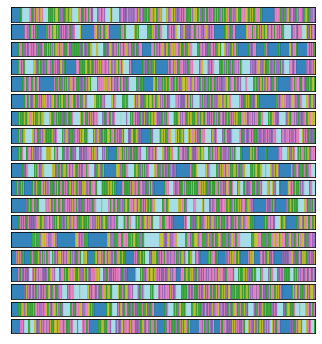

In [11]:
fig=hsmm_model.plot(draw=False)

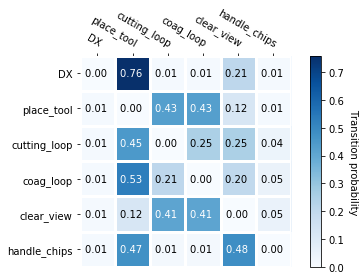

In [12]:
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 1d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [13]:
likes = hsmm_model.EM_fit(maxiter=5000)

/home/daniel/.conda/envs/virtamed/lib/python3.7/site-packages/pyhsmm-0.1.6-py3.7-linux-x86_64.egg/pyhsmm/internals/hsmm_states.py:92: RuntimeWarning: divide by zero encountered in log
  self._log_trans_matrix = np.log(self.trans_matrix)


KeyboardInterrupt: 

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

### 1e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 1f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 1g. Experiment Summary

The decoded sequences of the HSMM look quite promising. In fact the results are actually good however, we see that the model tend to favor longer smoother activities. It might be favored to have somewhat more granulary segmentation of the individual activties. A way to achieve this is to change the parameters of the duration distribution. However, we see that the changes of the activities are realtively strongly associated with the change of individual observables. Unless those do not change, the model decides to stay in a certain activity. That intuitively makes sense, but might also suggest that more observables could lead to a more better segmentation on a higher level of granularity.

---
---

## 2. Experiment - Added categorical RSD - 01/13/2020

In the following we catch up that idea and add a categorical version of the remaining surgery duration information to the model and see how the results change.

The complete setup of the experiment described in the remainder of the section looks thus as follows:

**Observables:**
 * NextPedalType (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * RSDProgressLevel (start/center/end)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

### 2a. Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_cat_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

###  2b. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### 2b. i) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

#### 1b. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### 2b. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

#### 2b. iv) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

#### 2b. vi) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-01,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02],[9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.78388174e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,3.36389129e-02,3.26195519e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,2.39549834e-02,1.27420125e-02,2.24259419e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,2.54840249e-02,1.58000954e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02],[1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,6.06076437e-02,1.66671020e-01,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,5.03402304e-03,1.00680461e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07],[1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.87471177e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,4.00406282e-02,5.44141871e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.77204349e-02,4.92807732e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.97738005e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07],[1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.38310778e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,2.35128322e-02,2.25907603e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,7.14605684e-02,1.42921137e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,2.02855807e-02,1.15258981e-02,6.82333169e-02,2.81231914e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02],[7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,6.32379091e-02,3.33562597e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08]]
cat_emission_weights = [[1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.24752442e-01,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02],[8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.78388338e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,3.36389437e-02,3.26195818e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,2.39550054e-02,1.27420241e-02,2.24259625e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,2.54840483e-02,1.58001099e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02],[1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,6.08354120e-02,1.67297383e-01,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,3.80221325e-03,7.60442649e-03,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07],[7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.87471974e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,4.00407392e-02,5.44143379e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.77205118e-02,4.92809098e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.97738830e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08],[1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.38310892e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,2.35128517e-02,2.25907791e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,7.14606277e-02,1.42921255e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,2.02855975e-02,1.15259077e-02,6.82333735e-02,2.81232148e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02],[6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.32380080e-02,3.33563119e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08]]
cat_emission_weights = np.array(cat_emission_weights)

### 2c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 2d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/final/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

### 2e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 2f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 2g. Experiment Summary

The decoded sequence indeed tends to have shorter sequences in general. We also see a marginal improvement in the sense that for no longer handle chips is the starting sequence for any trajectory. Before handle_chips was fitted to be the starting activity for the sequence 673. That is very surprising anyways. Probably a pedal is falsely reported to be active - we will investigate that.

In summary however, I would say that the other HSMM yielded the less granular but somewhat better results.

---
---

## 3. Experiment - Added categorical RSD and Valve2 - 01/13/2020

In the following we catch up that idea and add a categorical version of the remaining surgery duration information to the model and see how the results change.

The complete setup of the experiment described in the remainder of the section looks thus as follows:

**Observables:**
 * NextPedalType (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * RSDProgressLevel (start/center/end)
 * Turbidity (yes/no)
 * Valve2_OutChange (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

### 3a. Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_full_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

###  3b. Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

#### 3b. i) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

#### 3b. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

#### 3b. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

#### 3b. iv) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

#### 3b. vi) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,1.46289099e-02,5.79931785e-02,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.60913250e-08,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03,6.53076334e-03],[4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,8.77186704e-03,7.17698212e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,1.08983803e-02,1.32907076e-02,1.70121058e-02,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,1.24932652e-02,6.64535382e-03,6.64535382e-03,6.64535382e-03,1.16958227e-02,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,1.32907076e-02,6.64535382e-03,8.24023873e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,4.97072465e-08,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03,6.64535382e-03],[1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,3.27198721e-02,2.55624000e-02,8.07771841e-02,3.47648641e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,2.71768674e-03,1.03272096e-07,5.43537348e-03,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,2.55624000e-02,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07,1.03272096e-07],[5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.49411315e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,2.08108618e-02,1.33402960e-02,2.82814276e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.44075197e-02,1.33402960e-02,2.56133683e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.54747434e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,1.33402960e-02,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08,5.28275722e-08],[9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,7.55847094e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,1.15896554e-02,7.55847094e-03,1.23455025e-02,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,3.62806605e-02,9.07016513e-03,7.81041997e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,9.92679184e-08,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,1.03299103e-02,7.05457288e-03,6.29872578e-03,6.29872578e-03,3.25014250e-02,1.10857574e-02,1.13377064e-02,1.03299103e-02,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03,6.29872578e-03],[4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,8.96372035e-03,3.26279421e-02,8.96372035e-03,8.96372035e-03,1.72103431e-02,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08,4.08745648e-08]]
cat_emission_weights = [[5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,1.46289236e-02,5.79932330e-02,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,5.95606177e-08,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03,6.53076948e-03],[4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,8.77187543e-03,7.17698899e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,1.08983907e-02,1.32907203e-02,1.70121220e-02,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,1.24932771e-02,6.64536017e-03,6.64536017e-03,6.64536017e-03,1.16958339e-02,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,1.32907203e-02,6.64536017e-03,8.24024662e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,4.30619339e-08,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03,6.64536017e-03],[7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,3.27862470e-02,2.56142555e-02,8.09410473e-02,3.48353874e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,2.04914044e-03,7.78673366e-08,4.09828087e-03,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,2.56142555e-02,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08,7.78673366e-08],[3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.49411746e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,2.08109217e-02,1.33403345e-02,2.82815090e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.44075612e-02,1.33403345e-02,2.56134422e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.54747880e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,1.33403345e-02,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08,3.94873900e-08],[9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,7.55847780e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,1.15896660e-02,7.55847780e-03,1.23455137e-02,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,3.62806934e-02,9.07017336e-03,7.81042706e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,9.29692769e-08,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,1.03299197e-02,7.05457928e-03,6.29873150e-03,6.29873150e-03,3.25014545e-02,1.10857674e-02,1.13377167e-02,1.03299197e-02,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03,6.29873150e-03],[3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,8.96373482e-03,3.26279947e-02,8.96373482e-03,8.96373482e-03,1.72103708e-02,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08,3.19108959e-08]]
cat_emission_weights = np.array(cat_emission_weights)

### 3c. Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig = hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

### 3d. Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

### 3e. Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
### 3f. Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 3g. Experiment Summary

When using all categorical variables, i.e. additionally to the setup before the Valve2 value, the results are significantly worse. We see that for instance often coagulation activities are not detected and also the variety of activities that end a trajectory and start it increase, although typically the trajectory ends with the extraction of the chips and starts with the diagnosis. An explanation herefore is that the large number of parameters leads to a highly variable model that is very sensitive to noise. Especially the observable Valve2_OutChange however seems to be subject to high inter-run variability.

We will hence refrain from further considering an HSMM that uses all of the in this setup used categorical variables.

---
---

## 4. Control Experiments

We will for now pause the experimentation with different setups for an HSMM model with the derived NPT and or RSD feature and instead check, how the model performs without those.


---
### 4a. Turbidity Categorical HSMM - 01/13/2020

First, we will use the so far best performing model but exclude the NPT information yielding the following setup.



The complete setup of the experiment described in the remainder of the section looks thus as follows:

**Observables:**
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

#### 4a. i) Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  4a. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### 4a. ii) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### 4a. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### 4a. iii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### 4a. ii) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### 4a. ii) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[5.91118700e-07,5.91118700e-07,5.91118700e-07,5.91118700e-07,5.84109387e-02,5.84109387e-02,5.91118700e-07,5.91118700e-07,5.84109387e-02,5.84109387e-02,5.91118700e-07,5.91118700e-07,5.84109387e-02,5.84109387e-02,5.84109387e-02,5.91118700e-01],[5.16572451e-07,5.16572451e-07,5.16572451e-07,5.16572451e-07,6.90604881e-02,9.66846833e-02,5.16572451e-07,5.16572451e-07,6.90604881e-02,6.90604881e-02,5.16572451e-07,5.16572451e-07,2.51380177e-01,1.93369367e-01,6.90604881e-02,1.82319689e-01],[7.89217284e-07,7.89217284e-07,7.89217284e-07,7.89217284e-07,2.50049040e-01,6.87634861e-01,7.89217284e-07,7.89217284e-07,7.89217284e-07,7.89217284e-07,7.89217284e-07,7.89217284e-07,2.07688759e-02,4.15377518e-02,7.89217284e-07,7.89217284e-07],[5.68961633e-07,5.68961633e-07,5.68961633e-07,5.68961633e-07,5.68961633e-07,5.68961633e-07,5.68961633e-07,5.68961633e-07,2.24136401e-01,3.04595621e-01,5.68961633e-07,5.68961633e-07,1.78159703e-01,2.93101447e-01,5.68961633e-07,5.68961633e-07],[6.92439046e-07,6.92439046e-07,6.92439046e-07,6.92439046e-07,4.39364877e-02,5.27237853e-02,6.92439046e-07,6.92439046e-07,4.39364877e-02,4.39364877e-02,6.92439046e-07,6.92439046e-07,5.67659421e-01,1.59928815e-01,4.39364877e-02,4.39364877e-02],[4.76985173e-07,4.76985173e-07,4.76985173e-07,4.76985173e-07,1.04602012e-01,1.04602012e-01,4.76985173e-07,4.76985173e-07,1.04602012e-01,1.04602012e-01,4.76985173e-07,4.76985173e-07,3.80751322e-01,2.00835862e-01,4.76985173e-07,4.76985173e-07]]
cat_emission_weights = [[5.32708010e-07,5.32708010e-07,5.32708010e-07,5.32708010e-07,5.84109660e-02,5.84109660e-02,5.32708010e-07,5.32708010e-07,5.84109660e-02,5.84109660e-02,5.32708010e-07,5.32708010e-07,5.84109660e-02,5.84109660e-02,5.84109660e-02,5.91118976e-01],[4.47512210e-07,4.47512210e-07,4.47512210e-07,4.47512210e-07,6.90605262e-02,9.66847367e-02,4.47512210e-07,4.47512210e-07,6.90605262e-02,6.90605262e-02,4.47512210e-07,4.47512210e-07,2.51380316e-01,1.93369473e-01,6.90605262e-02,1.82319789e-01],[6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,2.53966416e-01,6.98407643e-01,6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,6.03170237e-07,1.58729010e-02,3.17458020e-02,6.03170237e-07,6.03170237e-07],[4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,4.25285186e-07,2.24136787e-01,3.04596147e-01,4.25285186e-07,4.25285186e-07,1.78160010e-01,2.93101952e-01,4.25285186e-07,4.25285186e-07],[6.48502787e-07,6.48502787e-07,6.48502787e-07,6.48502787e-07,4.39365032e-02,5.27238038e-02,6.48502787e-07,6.48502787e-07,4.39365032e-02,4.39365032e-02,6.48502787e-07,6.48502787e-07,5.67659621e-01,1.59928872e-01,4.39365032e-02,4.39365032e-02],[3.72383551e-07,3.72383551e-07,3.72383551e-07,3.72383551e-07,1.04602121e-01,1.04602121e-01,3.72383551e-07,3.72383551e-07,1.04602121e-01,1.04602121e-01,3.72383551e-07,3.72383551e-07,3.80751720e-01,2.00836072e-01,3.72383551e-07,3.72383551e-07]]
cat_emission_weights = np.array(cat_emission_weights)

#### 4a. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig = hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 4a. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
baseline_hsmm_model = hsmm_model

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

#### 4a. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 4a. v) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

#### 4a. vi) Experiment Summary

When we look at the resulting segmentation using the model, that does not make use of the RSD or NPT observable we see that the HSMM favors segmentations, where we have more shorter activities in general. This might be favored actually over the smooth activities, which we observed before. However, we also see more missclassification of certain activities (especially the state handle_chips and place tool are often switched). Moreover we see that for instance the clear_view activity is also more often misclassified as a handle_chips or place_tool activity.

We will try to improve the results by adding the movement direction to the observables.

---

### 4b. Categorical Controll Experiment with HandleMov - 01/13/2020

The complete setup of the experiment described in the remainder of the section looks thus as follows:

**Observables:**
 * HandleMov(fwds/still/bwds)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

#### 4b. i) Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/cat_control_mov_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  4b. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### 4b. ii) Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### 4a. ii) Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### 4b. ii) Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### 4b. ii) Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### 4b. ii) Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[3.05553315e-07,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.01930153e-02,8.09172810e-02,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.01930153e-02,2.00481622e-01,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.05553315e-07,3.05553315e-07,3.01930153e-02,3.01930153e-02,3.01930153e-02,8.45404428e-02],[2.45405379e-07,2.45405379e-07,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.54328622e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,8.13643502e-02,8.00520220e-02,3.28082057e-02,6.16794267e-02,2.45405379e-07,2.45405379e-07,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,3.28082057e-02,4.06821751e-02,2.45405379e-07,2.45405379e-07,2.45405379e-07,2.45405379e-07,3.28082057e-02,4.33068315e-02,2.45405379e-07,2.45405379e-07,3.28082057e-02,3.28082057e-02,2.45405379e-07,2.45405379e-07,7.08657243e-02,4.46191598e-02,3.28082057e-02,4.98684727e-02],[4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.09659885e-01,1.09659885e-01,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,5.82928864e-03,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.09659885e-01,1.09659885e-01,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.40364653e-01,3.86002796e-01,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,4.43025936e-07,1.16585773e-02,1.74878659e-02,4.43025936e-07,4.43025936e-07],[2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,8.82344533e-02,1.01603310e-01,2.64703360e-07,2.64703360e-07,6.68442828e-02,1.09624624e-01,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,6.68442828e-02,6.68442828e-02,2.64703360e-07,2.64703360e-07,6.68442828e-02,6.68442828e-02,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,2.64703360e-07,8.28869107e-02,1.06950852e-01,2.64703360e-07,2.64703360e-07,8.28869107e-02,9.35819959e-02,2.64703360e-07,2.64703360e-07],[4.06600779e-07,4.06600779e-07,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,1.70276976e-01,5.98549371e-02,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,4.06600779e-07,4.06600779e-07,2.57995418e-02,3.09594502e-02,4.06600779e-07,4.06600779e-07,2.57995418e-02,2.57995418e-02,4.06600779e-07,4.06600779e-07,1.88852646e-01,5.98549371e-02,2.57995418e-02,2.57995418e-02],[2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,9.83296173e-02,6.30793771e-02,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,4.63818949e-02,4.63818949e-02,2.11501441e-07,2.11501441e-07,1.16882375e-01,7.23557561e-02,2.11501441e-07,2.11501441e-07]]
cat_emission_weights = [[2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,8.09173396e-02,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,2.00481767e-01,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,8.45405041e-02],[2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.54328901e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,8.13644142e-02,8.00520850e-02,3.28082316e-02,6.16794753e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,3.28082316e-02,4.06822071e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,4.33068656e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,7.08657801e-02,4.46191949e-02,3.28082316e-02,4.98685120e-02],[3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,1.10618018e-01,1.10618018e-01,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,4.42472073e-03,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,1.10618018e-01,1.10618018e-01,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,1.41591063e-01,3.89375424e-01,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,3.36278776e-07,8.84944146e-03,1.32741622e-02,3.36278776e-07,3.36278776e-07],[1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,8.82346656e-02,1.01603554e-01,1.97859553e-07,1.97859553e-07,6.68444437e-02,1.09624888e-01,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,8.28871101e-02,1.06951110e-01,1.97859553e-07,1.97859553e-07,8.28871101e-02,9.35822211e-02,1.97859553e-07,1.97859553e-07],[3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.70277082e-01,5.98549741e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,3.09594694e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.88852763e-01,5.98549741e-02,2.57995578e-02,2.57995578e-02],[1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,9.83297541e-02,6.30794649e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.16882538e-01,7.23558568e-02,1.65119776e-07,1.65119776e-07]]
cat_emission_weights = np.array(cat_emission_weights)

#### 4b. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig = hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 4b. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

#### 4b. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 4b. v) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

#### 4b. vi) Experiment Summary

The resulting segmentation, where we try to compensate the loss of information by excluding the NPT and RSD observable with introducing the HandleMov observable, is significantly worse. We see that now the segmentation favors very short sequences. An explanation is that similar to the Valve2_OutChange variable this observable is subject to high inter-sample variability. As a consequence the initialization, which is based on the annotated sequence 692 does not generalize well.

While it is slighlty more expressed in this case as well, we see that the more symbols we have the more often those naturally change throughout the series. Those changes of symbols often trigger a switch of the state. It seems that at least the MPE path obtained by the Viterbi is obtained by almost deterministic linkages between observing a certain symbol and a specific state. It would be interested to derive a probabilistic measure of the individual states for the individual observation.

---
---

## 5. Experiments with Predicted observations

In the following we will conduct experiments, where we use the prediction that are made from our trained CNNs for the RSD- and NextPedalType-related variables instead of the ground truth data. We will see how that affects the performance of the individual models.

We will use the same initialization and setups as we had it before for the ground truth data.

Note that the predicted results will be obtained from the models that were trained not only on medium length sequences but also short and long sequences. The trajectories that the RSD model was not trained on are:
* 285
* 257
* 562
* 973
* 838
* 399
* 229
* 638
* 022
* 548
* 503
* 671

---

### 5a. Initial Experiment - Predicted Version 01/20/2020

The first experiment that we will conduct has the following setup:

**Observables:**
 * NextPedalTypePredicted (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 
We will not make use of the Bayesian formulation of the HSMM model components namely the emission, transition, duration and initial state distribution model. For that reason even though we define sometimes respective hyperparameters, those will be chosen in such a way that they essential are uninformative priors. The results will thus be purely identified by the data.
 
As for the model components we make the following distributional assumptions:
 
 * categorical emission model
 * categorical transition model
 * negative binomial duration distribution model
 * categorical initial state distribution model

#### 5a.  i) Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_mix_npt_pyhsmm_data_predicted/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  5a. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 1

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
#duration_negbin_rs = np.array([2000.171344, 100.477453 , 100.446388,  150.481516,  100.454518, 1000.125309])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])
#duration_negbin_ps = np.array([0.05717104, 0.07135187, 0.07054303, 0.07130548, 0.07084420, 0.09145630])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.33615819,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429,0.01412429],[0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.03115265,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.07943925,0.07632399,0.01557632,0.07943925,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.05451713,0.02492212,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632,0.01557632],[0.01798561,0.01798561,0.01798561,0.01798561,0.03057554,0.13129496,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.02158273,0.02517986,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561,0.01798561],[0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0234657,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.0433213,0.06859206,0.01805054,0.01805054,0.02166065,0.05956679,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.01805054,0.02527076,0.01805054,0.01805054,0.01805054],[0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01766784,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.04240283,0.04004711,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.16489988,0.0188457,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.01177856,0.17903416,0.05418139,0.01177856,0.01177856],[0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.01757469,0.13356766,0.05799649,0.01757469,0.01757469]]
cat_emission_weights = [[2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.05553536e-01,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,2.75360499e-07,2.75360499e-07,3.01930372e-02,3.01930372e-02,3.01930372e-02,3.01930372e-02],[2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,4.59315242e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,8.66137313e-02,8.39890728e-02,3.28082316e-02,8.66137313e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,6.56164631e-02,4.06822071e-02,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,2.12597340e-07,2.12597340e-07,3.28082316e-02,3.28082316e-02,3.28082316e-02,3.28082316e-02],[3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.41591016e-01,3.89375293e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,8.84943849e-03,1.76988770e-02,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,1.10617981e-01,1.10617981e-01,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07,3.36278662e-07],[1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,6.68444437e-02,7.48657769e-02,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.04277332e-01,1.41710221e-01,1.97859553e-07,1.97859553e-07,7.21919991e-02,1.28341332e-01,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,1.97859553e-07,6.68444437e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07,7.75395546e-02,6.68444437e-02,1.97859553e-07,1.97859553e-07],[3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,3.09594694e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,5.26310979e-02,5.05671333e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.59957258e-01,3.19914517e-02,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,2.57995578e-02,2.57995578e-02,3.80801473e-07,3.80801473e-07,1.72341046e-01,6.29509211e-02,2.57995578e-02,2.57995578e-02],[1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,4.63819595e-02,4.63819595e-02,1.65119776e-07,1.65119776e-07,1.68830333e-01,8.90533622e-02,1.65119776e-07,1.65119776e-07]]
cat_emission_weights = np.array(cat_emission_weights)

#### 5a. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 5a. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')

---

#### 5a. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 5a. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

#### 5a. vii) Experiment Summary

When looking at the decoded sequence, we see that the performance is actually comparable to the one, we got for the ground truth data. We see that sometimes short coagualtion tasks are sometimes not identified or longer tasks tend to end slighlty early. This can be explained by the fact, that at these times the prediction for the next pedal type are off. 

Better predictions would certainly improve the quality as we see a better quality of the segmentation for the ground truth data. Another way could be to put more initial weight on symbols that basically represent a wrong prediction of the next pedal type, e.g. symbols that have a certain pedal activated but the next pedal type taking on the value of a different pedal.

---
---

### 5b. Experiment - Added categorical RSD - Predicted - 01/20/2020

For the sake of completeness, we will also examine the performance of an HSMM fitted to the setup were we add the predicted remaining surgery duration.

The complete setup of the experiment described in the remainder of the section looks thus as follows:

**Observables:**
 * NextPedalTypePredicted (cut/coag/none)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * RSDProgressLevelPredicted (start/center/end)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

#### 5b. i) Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_rsd_npt_pyhsmm_data_predicted/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  5b. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

#cat_emission_weights = [[1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-01,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.24752331e-07,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02,1.23273054e-02],[9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.78388174e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,3.36389129e-02,3.26195519e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,2.39549834e-02,1.27420125e-02,2.24259419e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,2.54840249e-02,1.58000954e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,9.53102532e-08,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02,1.27420125e-02],[1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,6.06076437e-02,1.66671020e-01,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,5.03402304e-03,1.00680461e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,4.73497217e-02,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07,1.91292876e-07],[1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.87471177e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,4.00406282e-02,5.44141871e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.77204349e-02,4.92807732e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,2.56670694e-02,2.56670694e-02,2.97738005e-02,2.56670694e-02,2.56670694e-02,2.56670694e-02,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07,1.01641595e-07],[1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.38310778e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,2.35128322e-02,2.25907603e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,7.14605684e-02,1.42921137e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.81648154e-07,1.15258981e-02,1.15258981e-02,2.02855807e-02,1.15258981e-02,6.82333169e-02,2.81231914e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02,1.15258981e-02],[7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,1.73730519e-02,1.73730519e-02,1.73730519e-02,1.73730519e-02,6.32379091e-02,3.33562597e-02,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08,7.92211169e-08]]
cat_emission_weights = [[1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.24752442e-01,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.12425125e-07,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02,1.23273164e-02],[8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.78388338e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,3.36389437e-02,3.26195818e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,2.39550054e-02,1.27420241e-02,2.24259625e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,2.54840483e-02,1.58001099e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,8.25683165e-08,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02,1.27420241e-02],[1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,6.08354120e-02,1.67297383e-01,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,3.80221325e-03,7.60442649e-03,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,4.75276656e-02,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07,1.44484103e-07],[7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.87471974e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,4.00407392e-02,5.44143379e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.77205118e-02,4.92809098e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,2.56671405e-02,2.56671405e-02,2.97738830e-02,2.56671405e-02,2.56671405e-02,2.56671405e-02,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08,7.59747359e-08],[1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.38310892e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,2.35128517e-02,2.25907791e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,7.14606277e-02,1.42921255e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.70122398e-07,1.15259077e-02,1.15259077e-02,2.02855975e-02,1.15259077e-02,6.82333735e-02,2.81232148e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02,1.15259077e-02],[6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,1.73730791e-02,1.73730791e-02,1.73730791e-02,1.73730791e-02,6.32380080e-02,3.33563119e-02,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08,6.18481616e-08]]
cat_emission_weights = np.array(cat_emission_weights)

#### 5b. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 5b. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

#### 5b. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 5b. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

#### 5b. vii) Experiment Summary

When we look at the results, we see that the problem we have seen before arising from the next pedal type prediction are even stronger expressed for this setup. We see that not only there is often a place tool action misclassified as a handle chips activity. An explanation is that the model has a significantly higher number of parameters and hence is more sensitive to the noise in the data, that partially originates from the error in the predictions of the next pedal type and or the remaining surgery duration.

---
---

## 6. Further Experiments

We will now conduct further experiments with a setup that we think might yield a good performance, while at the same time being a relative simple model. The idea of this setup originated from the analysis results of the first control experiment. We hope to by introducing an indicator that describes, whether or not the mid point of the surgical procedure (with respect to its time) is reached, we can reduce the number of misclassified activities, while maintaining the generalization capabilities of the model.

The setup of the experiment is the following:


**Observables:**
 * HalfTimeReached (yes/no)
 * PedalLeft_Cut (on/off)
 * PedalRight_Coag (on/off)
 * PedalsYetActivated (yes/no)
 * Turbidity (yes/no)
 
**States:**
 * Diagnosis (DX)
 * Place tool (PT)
 * Cutting loop (CTL)
 * Coag loop (CGL)
 * Clear view (CV)
 * Handle chips (HC)
 

The type of the model components is as before:
 * categorical emission model
 * negative binomial duration distribution model
 * categorical transition model
 * categorical initial state distribution model

---

### 6a. Ground Truth Experiment

#### 6a. i) Read in the data

We will use the data that has been obtained preprocessed to support the above described setup of our workflow example.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/turbidity_halftime_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  6a. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[3.63055216e-07,3.63055216e-07,3.63055216e-07,3.63055216e-07,3.98086860e-02,3.98086860e-02,3.63055216e-07,3.63055216e-07,3.98086860e-02,3.98086860e-02,3.63055216e-07,3.63055216e-07,3.98086860e-02,3.98086860e-02,3.98086860e-02,3.98086860e-02,3.63055216e-07,3.63055216e-07,3.63055216e-07,3.63055216e-07,3.98086860e-02,3.98086860e-02,3.63055216e-07,3.63055216e-07,3.98086860e-02,3.98086860e-02,3.63055216e-07,3.63055216e-07,3.98086860e-02,3.98086860e-02,3.98086860e-02,4.02863902e-01],[2.88254898e-07,2.88254898e-07,2.88254898e-07,2.88254898e-07,4.44837806e-02,4.44837806e-02,2.88254898e-07,2.88254898e-07,4.44837806e-02,4.44837806e-02,2.88254898e-07,2.88254898e-07,6.58359953e-02,8.00708051e-02,4.44837806e-02,4.44837806e-02,2.88254898e-07,2.88254898e-07,2.88254898e-07,2.88254898e-07,4.44837806e-02,6.22772928e-02,2.88254898e-07,2.88254898e-07,4.44837806e-02,4.44837806e-02,2.88254898e-07,2.88254898e-07,1.40568747e-01,8.89675612e-02,4.44837806e-02,1.17437181e-01],[4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,1.42043921e-01,2.21588517e-01,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,1.13635137e-02,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,1.81816219e-01,4.20450007e-01,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,4.31813520e-07,1.13635137e-02,1.13635137e-02,4.31813520e-07,4.31813520e-07],[2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,1.42334844e-01,1.45984455e-01,2.70071242e-07,2.70071242e-07,1.13137953e-01,1.67882124e-01,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,2.70071242e-07,9.12402845e-02,1.38685232e-01,2.70071242e-07,2.70071242e-07,9.12402845e-02,1.09488341e-01,2.70071242e-07,2.70071242e-07],[4.79840269e-07,4.79840269e-07,4.79840269e-07,4.79840269e-07,3.25095033e-02,3.25095033e-02,4.79840269e-07,4.79840269e-07,3.25095033e-02,3.25095033e-02,4.79840269e-07,4.79840269e-07,3.78410619e-01,8.32243285e-02,3.25095033e-02,3.25095033e-02,4.79840269e-07,4.79840269e-07,4.79840269e-07,4.79840269e-07,3.25095033e-02,3.90114040e-02,4.79840269e-07,4.79840269e-07,3.25095033e-02,3.25095033e-02,4.79840269e-07,4.79840269e-07,7.41216676e-02,6.76197669e-02,3.25095033e-02,3.25095033e-02],[2.28790727e-07,2.28790727e-07,2.28790727e-07,2.28790727e-07,6.42670581e-02,6.42670581e-02,2.28790727e-07,2.28790727e-07,6.42670581e-02,6.42670581e-02,2.28790727e-07,2.28790727e-07,2.33932092e-01,1.23392752e-01,2.28790727e-07,2.28790727e-07,2.28790727e-07,2.28790727e-07,2.28790727e-07,2.28790727e-07,6.42670581e-02,6.42670581e-02,2.28790727e-07,2.28790727e-07,6.42670581e-02,6.42670581e-02,2.28790727e-07,2.28790727e-07,6.42670581e-02,6.42670581e-02,2.28790727e-07,2.28790727e-07]]
cat_emission_weights = np.array(cat_emission_weights)

#### 6a. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 6a. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

#### 6a. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 6a. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

#### 6a. vii) Experiment Summary

When we look at the results we see that we only observe place tool actions in the first half and handle chips actions in the second. This can be explained by the fact, that both tend to have distributions that put high mass on symbols that only differ by the HalfTimeReached observable. By the initialzation, handle chips is has a higher likelihood in the second half for symbols, were both pedals are turned of and no turbidity is encountered, while place tool has a higher likelihood for those in the first half. This leads to the segmentation we see.

Since the results do nt look promising, we will refrain from looking how the model would perform with the predicted values for the halftime indicator. One could probably try to reduce the effect and say instead of using a halftime indicator, take an indicator hat says if you are in the last quarter of the surgery. This will likely give better results.

---

### 6b. Update gate 14

#### 6b. i) Read in the data

We will use the data that has been extended by the information of the end of the diagnosis information as given by the update gate 14.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/npt_pya_ugate14_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  6b. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[1.59662642e-07,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.77169511e-01,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.59662642e-07,1.59662642e-07,1.75068686e-02,1.75068686e-02,1.75068686e-02,1.75068686e-02],[1.18942052e-07,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.83552550e-02,2.56973570e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,4.84578731e-02,4.69894527e-02,1.83552550e-02,3.23052487e-02,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,3.67105099e-02,2.27605162e-02,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.83552550e-02,3.45078793e-02,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.18942052e-07,1.18942052e-07,1.83552550e-02,1.83552550e-02,1.83552550e-02,1.83552550e-02],[2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,8.51049724e-02,2.34038674e-01,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,5.31906078e-03,1.06381216e-02,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,6.64882597e-02,6.64882597e-02,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,6.64882597e-02,6.64882597e-02,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,6.64882597e-02,6.64882597e-02,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,6.64882597e-02,6.64882597e-02,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,6.64882597e-02,6.64882597e-02,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07,2.02124309e-07],[1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,3.70916949e-02,4.15426983e-02,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,5.78630441e-02,7.86343932e-02,1.09791417e-07,1.09791417e-07,4.00590305e-02,7.12160542e-02,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,4.30263661e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07,3.70916949e-02,3.70916949e-02,1.09791417e-07,1.09791417e-07],[2.35178989e-07,2.35178989e-07,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.91202430e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,3.25044132e-02,3.12297303e-02,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,9.87879224e-02,1.97575845e-02,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.06436020e-01,3.88778275e-02,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,2.35178989e-07,2.35178989e-07,1.59335359e-02,1.59335359e-02,1.59335359e-02,1.59335359e-02],[8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,9.20116367e-02,4.85336105e-02,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08,2.52779222e-02,2.52779222e-02,8.99894029e-08,8.99894029e-08]]
cat_emission_weights = np.array(cat_emission_weights)

#### 6b. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 6b. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

#### 6b. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 6b. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

#### 6b. vii) Experiment Summary


---

### 6c. Update gate 14 w/o PedalsYetActivated

#### 6c. i) Read in the data

We will use the data that has been extended by the information of the end of the diagnosis information as given by the update gate 14.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/npt_ugate14_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  6c. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.24290236e-01,2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02],[1.52542094e-07,1.52542094e-07,2.35404466e-02,3.29566252e-02,2.35404466e-02,2.35404466e-02,6.21467789e-02,7.81542825e-02,1.52542094e-07,1.52542094e-07,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,4.70808931e-02,2.91901537e-02,1.52542094e-07,1.52542094e-07,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,1.52542094e-07,1.52542094e-07,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,4.42560395e-02,1.52542094e-07,1.52542094e-07,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,1.52542094e-07,1.52542094e-07,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02],[2.02126270e-07,2.02126270e-07,8.51057981e-02,2.34040945e-01,2.02126270e-07,2.02126270e-07,5.31911238e-03,1.06382248e-02,2.02126270e-07,2.02126270e-07,6.64889048e-02,6.64889048e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,6.64889048e-02,6.64889048e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,6.64889048e-02,6.64889048e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,6.64889048e-02,6.64889048e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,6.64889048e-02,6.64889048e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07],[1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,3.70918904e-02,3.70918904e-02,3.70918904e-02,4.15429172e-02,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,5.78633490e-02,7.86348076e-02,4.00592416e-02,7.12164296e-02,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,3.70918904e-02,3.70918904e-02,4.30265929e-02,3.70918904e-02,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02],[2.90779127e-07,2.90779127e-07,1.97004829e-02,2.36405794e-02,1.97004829e-02,1.97004829e-02,4.01889851e-02,3.86129464e-02,2.90779127e-07,2.90779127e-07,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.22142994e-01,2.44285988e-02,2.90779127e-07,2.90779127e-07,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.31599226e-01,4.80691782e-02,2.90779127e-07,2.90779127e-07,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,2.90779127e-07,2.90779127e-07,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,2.90779127e-07,2.90779127e-07,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02],[8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,9.20120341e-02,4.85338202e-02,8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02]]
cat_emission_weights = np.array(cat_emission_weights)

#### 6c. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 6c. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

#### 6c. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 6c. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

#### 6c. vii) Experiment Summary


---

### 6d. Update gate 14 w/o PedalsYetActivated & NPT

#### 6d. i) Read in the data

We will use the data that has been extended by the information of the end of the diagnosis information as given by the update gate 14.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/ugate14_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  6d. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[4.31817436e-07,4.31817436e-07,4.73484031e-02,4.73484031e-02,4.73484031e-02,4.73484031e-02,4.73484031e-02,4.73484031e-02,4.31817436e-07,4.31817436e-07,4.73484031e-02,4.73484031e-02,4.73484031e-02,4.73484031e-02,4.73484031e-02,4.79165839e-01],[3.50648859e-07,3.50648859e-07,5.41124782e-02,7.57574695e-02,5.41124782e-02,5.41124782e-02,1.96969421e-01,1.92640422e-01,3.50648859e-07,3.50648859e-07,5.41124782e-02,5.41124782e-02,5.41124782e-02,5.41124782e-02,5.41124782e-02,1.01731459e-01],[4.31816317e-07,4.31816317e-07,1.81817397e-01,4.99997841e-01,4.31816317e-07,4.31816317e-07,1.13635873e-02,2.27271746e-02,4.31816317e-07,4.31816317e-07,1.42044841e-01,1.42044841e-01,4.31816317e-07,4.31816317e-07,4.31816317e-07,4.31816317e-07],[2.70072409e-07,2.70072409e-07,2.70072409e-07,2.70072409e-07,1.42335459e-01,1.93430239e-01,1.13138442e-01,1.86130985e-01,2.70072409e-07,2.70072409e-07,2.70072409e-07,2.70072409e-07,9.12406788e-02,9.12406788e-02,9.12406788e-02,9.12406788e-02],[5.51568290e-07,5.51568290e-07,3.73691253e-02,4.48429504e-02,3.73691253e-02,3.73691253e-02,4.82809099e-01,1.36023616e-01,5.51568290e-07,5.51568290e-07,3.73691253e-02,3.73691253e-02,3.73691253e-02,3.73691253e-02,3.73691253e-02,3.73691253e-02],[2.28791564e-07,2.28791564e-07,6.42672934e-02,6.42672934e-02,6.42672934e-02,6.42672934e-02,2.33932948e-01,1.23393203e-01,2.28791564e-07,2.28791564e-07,6.42672934e-02,6.42672934e-02,6.42672934e-02,6.42672934e-02,6.42672934e-02,6.42672934e-02]]  # updated anyways not important (artifact from previous implementation)
cat_emission_weights = np.array(cat_emission_weights)

#### 6d. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 6d. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

#### 6d. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 6d. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 6e. Update gate 14 & RSPLevel w/o PedalsYetActivated & NPT

#### 6e. i) Read in the data

We will use the data that has been extended by the information of the end of the diagnosis information as given by the update gate 14.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/rsp_ugate14_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  6e. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.760, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.010, 0.000, 0.430, 0.430, 0.120, 0.010],       #place tool
  [0.010, 0.450, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.010, 0.530, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.010, 0.450, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.010, 0.060, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[2.02127169e-07,2.02127169e-07,2.02127169e-07,2.02127169e-07,2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.02127169e-07,2.02127169e-07,2.02127169e-07,2.02127169e-07,2.02127169e-07,2.02127169e-07,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.24290236e-01,2.21630668e-02,2.21630668e-02,2.21630668e-02,2.21630668e-02],[1.52542094e-07,1.52542094e-07,1.52542094e-07,1.52542094e-07,1.52542094e-07,1.52542094e-07,2.35404466e-02,2.35404466e-02,2.35404466e-02,3.29566252e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,8.56872254e-02,8.38039897e-02,2.35404466e-02,2.35404466e-02,1.52542094e-07,1.52542094e-07,1.52542094e-07,1.52542094e-07,1.52542094e-07,1.52542094e-07,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,4.42560395e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02,2.35404466e-02],[2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,6.64889048e-02,6.64889048e-02,8.51057981e-02,2.34040945e-01,6.64889048e-02,6.64889048e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,5.31911238e-03,1.06382248e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,6.64889048e-02,6.64889048e-02,6.64889048e-02,6.64889048e-02,6.64889048e-02,6.64889048e-02,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07,2.02126270e-07],[1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,3.70918904e-02,3.70918904e-02,5.78633490e-02,7.86348076e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,4.59939441e-02,7.56674564e-02,3.70918904e-02,3.70918904e-02,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,1.09791996e-07,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02,3.70918904e-02],[2.90779127e-07,2.90779127e-07,2.90779127e-07,2.90779127e-07,2.90779127e-07,2.90779127e-07,1.97004829e-02,1.97004829e-02,1.97004829e-02,2.36405794e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.57603863e-01,4.33410623e-02,1.16626859e-01,4.80691782e-02,2.90779127e-07,2.90779127e-07,2.90779127e-07,2.90779127e-07,2.90779127e-07,2.90779127e-07,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02,1.97004829e-02],[8.99897916e-08,8.99897916e-08,8.99897916e-08,8.99897916e-08,8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,9.20120341e-02,4.85338202e-02,8.99897916e-08,8.99897916e-08,8.99897916e-08,8.99897916e-08,8.99897916e-08,8.99897916e-08,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02,2.52780313e-02]]
cat_emission_weights = np.array(cat_emission_weights)

#### 6e. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 6e. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

#### 6e. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 6e. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

---

### 6f. Update gate 14 & RSPLevel w/o PedalsYetActivated & NPT

#### 6f. i) Read in the data

We will use the data that has been extended by the information of the end of the diagnosis information as given by the update gate 14.

In [ ]:
root_dir = '/home/daniel/PycharmProjects/virtamed/Data/hsmm-experiments/lsp_ugate14_pyhsmm_data/pyhsmm_data/'

obs_array, records, data_frames, eaf_fnames = read_data_from_disk(root_dir)

---

####  6f. ii) Configuration of the HSMM

After reading in the data, we will now configure the HSMM model. This involvs setting the initial values for the individual parts of the HSMM model namely the transition, emission, duration and intial state distribution model.

##### Basic setup

First we define the number of emission symbols that are present in the data and the state space of our model.

In [ ]:
state_list = ['DX', 'place_tool', 'cutting_loop', 'coag_loop', 'clear_view', 'handle_chips']

##### Configuration of the transition model

The transition model is given by categorical distribution namely the Dirichlet distribution. We will define a multinomial likelihood model and a Dirichlet prior distribution by providing the respective parameters.



In [ ]:
initial_state_transition_likelihood = [
  [0.000, 0.770, 0.010, 0.010, 0.210, 0.010],       #DX
  [0.000, 0.000, 0.435, 0.430, 0.120, 0.010],       #place tool
  [0.000, 0.460, 0.000, 0.250, 0.250, 0.040],       #cutting loop
  [0.000, 0.540, 0.210, 0.000, 0.200, 0.050],       #coag loop
  [0.000, 0.460, 0.200, 0.250, 0.000, 0.050],       #clear view
  [0.000, 0.070, 0.015, 0.015, 0.900, 0.000]        #handle chips
  #[0.010, 0.475, 0.015, 0.015, 0.485, 0.000]
]

initial_state_transition_likelihood = np.array(initial_state_transition_likelihood)

# Uninformative Dirichlet prior
dirichlet_state_transition_prior_alpha = 0
dirichlet_state_transition_prior_alpha = np.array(dirichlet_state_transition_prior_alpha)

##### Initial State distribution model

We will now define the prior guess for the initial state distribution, that will be given by a multinomial distribution.

In [ ]:
init_state_pi_0 = [0.990, 0.002, 0.002, 0.002, 0.002, 0.002]
init_state_pi_0 = np.array(init_state_pi_0)

# Uninformative Dirichlet prior
init_state_dirichlet_prior = 0

##### Negative Binomial duration distribution model 

We will now initialize the negative binomial duration distribution model hyper parameters.

The values are chosen in such a way that the distribution looks similar to a Gaussian distribution with the first and the second moment being close to what we expect them to be. Our expectations are based on what we have observed for the annotated sequence.

In [ ]:
duration_negbin_rs = np.array([248.813,  32.494,  33.214,  31.712,  31.963, 149.621])
duration_negbin_ps = np.array([0.11982199, 0.07122912, 0.07256167, 0.07113063, 0.07079434, 0.09604035])

##### Categorical emission model

Last but not least we define the categorical emission model that is defined by a multinomial likelihood and an uninformative Dirichlet prior.

In [ ]:
cat_emission_dirichlet_prior_alpha_0=0

cat_emission_weights = [[2.75361712e-07,2.75361712e-07,2.75361712e-07,2.75361712e-07,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,2.75361712e-07,2.75361712e-07,2.75361712e-07,2.75361712e-07,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.01931702e-02,3.05554882e-01],[2.12598064e-07,2.12598064e-07,2.12598064e-07,2.12598064e-07,3.28083432e-02,3.28083432e-02,3.28083432e-02,4.59316804e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,1.19422369e-01,1.16797702e-01,2.12598064e-07,2.12598064e-07,2.12598064e-07,2.12598064e-07,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,3.28083432e-02,6.16796851e-02],[2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,9.05791614e-02,9.05791614e-02,1.15941327e-01,3.18838648e-01,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,7.24633291e-03,1.44926658e-02,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,9.05791614e-02,9.05791614e-02,9.05791614e-02,9.05791614e-02,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07,2.75360651e-07],[1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,5.27424843e-02,5.27424843e-02,8.22782755e-02,1.11814067e-01,6.11812818e-02,5.27424843e-02,5.69618830e-02,1.07594668e-01,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,1.56117753e-07,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02,5.27424843e-02],[3.80803793e-07,3.80803793e-07,3.80803793e-07,3.80803793e-07,2.57997150e-02,2.57997150e-02,2.57997150e-02,3.09596580e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,1.72342096e-01,6.29513046e-02,1.86789937e-01,5.67593730e-02,3.80803793e-07,3.80803793e-07,3.80803793e-07,3.80803793e-07,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02,2.57997150e-02],[1.29172581e-07,1.29172581e-07,1.29172581e-07,1.29172581e-07,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,1.32075335e-01,6.96661109e-02,3.62844328e-02,3.62844328e-02,1.29172581e-07,1.29172581e-07,1.29172581e-07,1.29172581e-07,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02,3.62844328e-02]]
cat_emission_weights = np.array(cat_emission_weights)

#### 6f. iii) Initialization of the HSMM

After having defined all hyperparameter the model is now fully defined.
We will now create an instance of an HSMM with the given hyperparameters that can be used for the final experiments.

In [ ]:
dur_distns = []
categoricals = []

for state in range(len(state_list)):
    dur_distns.append(NegativeBinomialFixedRDuration(r=duration_negbin_rs[state], p=duration_negbin_ps[state]))
    
    categoricals.append(Categorical(weights=cat_emission_weights[state, :],
                                    K=cat_emission_weights.shape[1], 
                                    alpha_0=cat_emission_dirichlet_prior_alpha_0))

In [ ]:
hsmm_model = HSMM(obs_distns = categoricals, dur_distns=dur_distns, 
                  trans_matrix=initial_state_transition_likelihood, 
                  alpha = dirichlet_state_transition_prior_alpha, 
                  pi_0=init_state_pi_0, init_state_concentration=init_state_dirichlet_prior)

for obs in obs_array:
    # We will only add the last observable as this is the encoded categorical symbol for our given initialization.
    hsmm_model.add_data(obs[:,-1].astype(np.int32))

In [ ]:
fig=hsmm_model.plot()
transmat = hsmm_model.plot_trans_distn(state_list)

---

#### 6f. iv) Parameter Estimation using the BWA

We will now fit the model using the BWA.

In [ ]:
likes = hsmm_model.EM_fit(maxiter=5000)

In [ ]:
print('Log-Likelihood at convergence ', likes[-1])

In [ ]:
update_gate_hsmm_model = hsmm_model

In [ ]:
import time
import os

date = datetime.datetime.strptime(time.ctime(), "%a %b %d %H:%M:%S %Y")
timestamp = datetime.datetime.strftime(date, "%Y%m%d_%H%M%S")
output_dir = '../../data/experiments/'+ timestamp+'/'
os.mkdir(output_dir)

In [ ]:
plt.figure()
hsmm_model.plot()
plt.gcf().suptitle('Fit after BWA')
plt.savefig(output_dir+'pyhsmm_bwa_fit.png')
plt.show()


In [ ]:
plt.close()
plt.figure()
plt.title('Log-Likelihood during BWA')
plt.plot(likes)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.savefig(output_dir+'pyhsmm_ll_conv.png')

plt.show()

In [ ]:
plt.close()
hsmm_model.total_summary(state_list)

In [ ]:
transmat = hsmm_model.plot_trans_distn(state_list)
transmat.savefig(output_dir+'pyhsmm_transmat_fit.png')
plt.show()

---

#### 6f. v) Decodition

We will now use the fitted model to decode the state_sequences that are given and write the results to the respective eaf files.

In [ ]:
for i in range(len(hsmm_model.stateseqs)):
    state_seq = hsmm_model.stateseqs[i]
    eaf_file = '/home/daniel/PycharmProjects/virtamed/'+eaf_fnames[i]
    data_frame = data_frames[i]
    
    to_eaf(state_seq, data_frame, state_list, eaf_file, output_dir=output_dir)

---
#### 6f. vi) Save model to disk

Last but not least we will save the fitted model as a pickle file to disk.

In [ ]:
import pickle
with open(output_dir+'fitted_pyhsmm_model.pkl', 'wb') as f:
    pickle.dump(hsmm_model, f)

----
## Visualization of the segmentation of the 692 sequence

In [ ]:
baseline_segmentation = baseline_hsmm_model.stateseqs[2]

In [ ]:
update_gate_segmentation = update_gate_hsmm_model.stateseqs[2]

In [ ]:
ground_truth_692 = np.array(['DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','DX','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','cutting_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','place_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','coag_loop','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','clear_view','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips','handle_chips'])

In [ ]:
state_dict = {0:'DX', 1:'place_loop', 2:'cutting_loop', 3:'coag_loop', 4:'clear_view', 5:'handle_chips'}
baseline_segmentation_encoded = np.array([state_dict[state] for state in baseline_segmentation])
update_gate_segmentation_encoded = np.array([state_dict[state] for state in update_gate_segmentation])
inverse_state_dict = {v:k for k,v in state_dict.items()}
ground_truth_segmentation_num = np.array([inverse_state_dict[state] for state in ground_truth_692])

In [ ]:
ground_truth_segmentation_num

In [ ]:
np.sum(ground_truth_692 == update_gate_segmentation_encoded)

In [ ]:
np.sum(ground_truth_692 == baseline_segmentation_encoded)

In [ ]:
tmp_hsmm = update_gate_hsmm_model

In [ ]:
tmp_hsmm.add_data(data = obs_array[2][:,-1].astype(np.int32), fixed_stateseq=True, stateseq=list(baseline_segmentation))
tmp_hsmm.add_data(data = obs_array[2][:,-1].astype(np.int32), fixed_stateseq=True, stateseq=list(update_gate_segmentation))
tmp_hsmm.add_data(data = obs_array[2][:,-1].astype(np.int32), fixed_stateseq=True, stateseq=list(ground_truth_segmentation_num))
tmp_hsmm.states_list = update_gate_hsmm_model.states_list[-3:]

In [ ]:
import matplotlib.patches as mpatches
color_dict = update_gate_hsmm_model._get_colors()
patch_list = []
state_dict_thesis = {0:'diagnosis', 1:'position hysteroscope', 2:'cutting', 
                     3:'coagulation', 4: 'clear view', 5:'handle chips'}
for k,v in color_dict.items():
    v = v[0], v[1], v[2], 0.9
    patch = mpatches.Patch(color=v, label = state_dict_thesis[k])
    patch_list.append(patch)

In [ ]:
tmp_hsmm.plot()
#plt.legend(handles=patch_list, loc='center left', bbox_to_anchor=(1.1, 1.7))
plt.legend(handles=patch_list, bbox_to_anchor=(0.95, -0.15),
          fancybox=True, shadow=False, ncol=2)